In [1]:
import numpy as np
import os
import seaborn as sns
import scipy.stats as stat
from scipy.stats import pearsonr
from scipy.stats import pointbiserialr
import pandas as pd
import matplotlib.pyplot as plt
from pydataset import data
import warnings
warnings.filterwarnings("ignore")
import wrangle as wra
import env
import explore as exp
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 
from math import sqrt
import statsmodels.api as sm

### 1. Load your zillow dataset.

In [2]:
zillow_query = """
        select bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt,
        taxamount, fips
        from properties_2017
        where propertylandusetypeid = '261';
        """

zillow_df = wra.get_zillow_data(zillow_query)

zillow_df.head()

,Unnamed: 0,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


In [3]:
df = zillow_df

In [4]:
df = wra.wrangle_zillow(df)

In [5]:
df.head()

,bedroomcnt,bathroomcnt,squarefeet,taxvalue,yearbuilt,taxamount,county
4,4,2.0,3633,296425,2005,6941.39,LA
6,3,4.0,1620,847770,2011,10244.94,LA
7,3,2.0,2077,646760,1926,7924.68,LA
11,0,0.0,1200,5328,1972,91.60,LA
14,0,0.0,171,6920,1973,255.17,LA


In [6]:
train, validate, test = wra.split_data(df)

In [7]:
#to_scale = ['bedroomcnt','bathroomcnt','squarefeet','yearbuilt','taxamount']

In [8]:
#train, validate, scale = exp.scale_data(train, validate, test, to_scale)

### 2. Fit a linear regression model (ordinary least squares) and compute yhat, predictions of taxvaluedollarcnt using only calculatedfinishedsqft.

In [9]:
# Fit a linear regression model using OLS
X = sm.add_constant(df['squarefeet'])
model = sm.OLS(df['taxvalue'], X).fit()

# Compute the predicted values of 'taxvaluedollarcnt'
yhat = model.predict(X)

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               taxvalue   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                 7.663e+05
Date:                Wed, 10 May 2023   Prob (F-statistic):               0.00
Time:                        12:12:33   Log-Likelihood:            -2.7775e+07
No. Observations:             2033172   AIC:                         5.555e+07
Df Residuals:                 2033170   BIC:                         5.555e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        5.61e+04    379.799    147.711      0.0

In [10]:
#create baseline of y-target
baseline = train.taxvalue.mean()
baseline

363532.06723244983

In [11]:
# make it
lr = LinearRegression()

# fit it to training data
lr.fit(train[['squarefeet']], train.taxvalue)

# use it
# we will use lr.predict to make predictions 
lr.predict(train[['squarefeet']])

array([580049.24806397, 584607.35349842, 507294.8728601 , ...,
       379141.98545281, 302881.37529937, 331807.81363343])

In [12]:
train['yhat'] = lr.predict(train[['squarefeet']])
train.head()

,bedroomcnt,bathroomcnt,squarefeet,taxvalue,yearbuilt,taxamount,county,yhat
1571798,4,2.5,2987,885000,2006,13617.38,Orange,580049.248064
1723553,3,2.0,3013,489511,1977,5768.57,LA,584607.353498
718174,4,3.0,2572,390915,1986,4944.11,LA,507294.872860
1663205,3,1.0,1589,321758,1959,4031.78,LA,334963.425088
1087891,3,2.0,1727,231737,1962,2708.80,Ventura,359156.446240


### 3. Plot the residuals for the linear regression model that you made

In [13]:
# residual = actual - predicted
train['baseline_residual'] = train.taxvalue - baseline

In [14]:
train.head()

,bedroomcnt,bathroomcnt,squarefeet,taxvalue,yearbuilt,taxamount,county,yhat,baseline_residual
1571798,4,2.5,2987,885000,2006,13617.38,Orange,580049.248064,521467.932768
1723553,3,2.0,3013,489511,1977,5768.57,LA,584607.353498,125978.932768
718174,4,3.0,2572,390915,1986,4944.11,LA,507294.872860,27382.932768
1663205,3,1.0,1589,321758,1959,4031.78,LA,334963.425088,-41774.067232
1087891,3,2.0,1727,231737,1962,2708.80,Ventura,359156.446240,-131795.067232


In [15]:
# residual = actual - predicted
train['residuals'] = train.yhat - train.taxvalue
train.head()

,bedroomcnt,bathroomcnt,squarefeet,taxvalue,yearbuilt,taxamount,county,yhat,baseline_residual,residuals
1571798,4,2.5,2987,885000,2006,13617.38,Orange,580049.248064,521467.932768,-304950.751936
1723553,3,2.0,3013,489511,1977,5768.57,LA,584607.353498,125978.932768,95096.353498
718174,4,3.0,2572,390915,1986,4944.11,LA,507294.872860,27382.932768,116379.872860
1663205,3,1.0,1589,321758,1959,4031.78,LA,334963.425088,-41774.067232,13205.425088
1087891,3,2.0,1727,231737,1962,2708.80,Ventura,359156.446240,-131795.067232,127419.446240


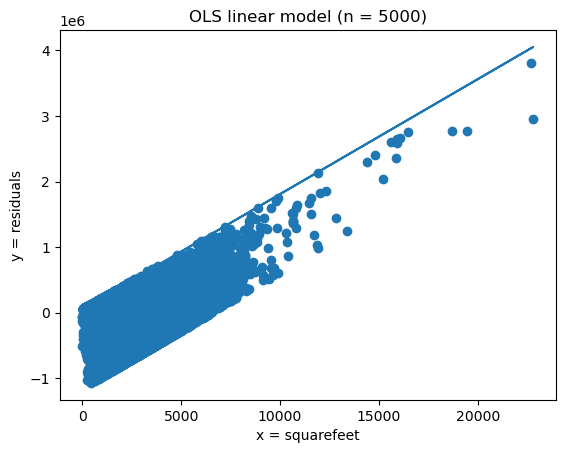

In [16]:
# visualize the line of best fit from OLS linear model

# scatter is my actuals
plt.scatter(train.squarefeet, train.residuals)

# lineplot is my regression line
plt.plot(train.squarefeet, train.yhat)

plt.xlabel('x = squarefeet')
plt.ylabel('y = residuals')
plt.title('OLS linear model (n = 5000)')
#plt.text(5000, 5000000, 'n = 5000', fontsize=12, color='red')

plt.show()

### 4. Calculate the sum of squared errors, explained sum of squares, total sum of squares, mean squared error, and root mean squared error for your model.

In [19]:
# the difference between yhat and y, just squared
train['baseline_residual_2'] = train.baseline_residual ** 2
train['residual_2'] = train.residuals **2 

In [17]:
# Calculate the mean taxvalue
mean_taxvalue = np.mean(train['taxvalue'])

# Calculate the SSE, MSE, and RMSE
SSE = np.sum((train['taxvalue'] - mean_taxvalue)**2)
MSE = SSE / len(train)
RMSE = np.sqrt(MSE)

# Print the results
print("SSE:", SSE)
print("MSE:", MSE)
print("RMSE:", RMSE)

SSE: 7.220942982660589e+16
MSE: 59192812067.367615
RMSE: 243295.7296529629


### 5. Calculate the sum of squared errors, mean squared error, and root mean squared error for the baseline model (i.e. a model that always predicts the average taxvaluedollarcnt amount).

### 6. Write python code that compares the sum of squared errors for your model against the sum of squared errors for the baseline model and outputs whether or not your model performs better than the baseline model.

In [21]:
#add the residuals together
SSE_baseline = train.baseline_residual_2.sum()
SSE = train.residual_2.sum()

In [22]:
print("SSE_baseline =", "{:.1f}".format(SSE_baseline))
print('SSE =', "{:.1f}".format(SSE))

SSE_baseline = 72209429826605888.0
SSE = 52446247997834368.0


### 7. What is the amount of variance explained in your model?

In [23]:
#use r2_score
r2_score(train.taxvalue, train.yhat)

0.27369253401153004

### 8. Is your model better than the baseline model?

In [24]:
SSE_baseline - SSE

1.976318182877152e+16

### A: Our model is better than baseline, but less than awesome.

### 9. Create a file named evaluate.py that contains the following functions.

* plot_residuals(y, yhat): creates a residual plot
* regression_errors(y, yhat): returns the following values:
    * sum of squared errors (SSE)
    * explained sum of squares (ESS)
    * total sum of squares (TSS)
    * mean squared error (MSE)
    * root mean squared error (RMSE)
* baseline_mean_errors(y): computes the SSE, MSE, and RMSE for the baseline model
* better_than_baseline(y, yhat): returns true if your model performs better than the baseline, otherwise false